# Understanding Tree SHAP for Simple Models

The SHAP value for a feature is the average change in model output by conditioning on that feature when introducing features one at a time over all feature orderings. While this is easy to state, it is challenging to compute. So this notebook is meant to give a few simple examples where we can see how this plays out for very small trees. For arbitrary large trees it is very hard to intuitively guess these values by looking at the tree.

In [1]:
import graphviz
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeRegressor, export_graphviz

import shap

## Single split example

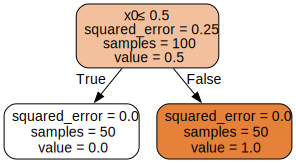

In [2]:
# build data
N = 100
M = 4
X = np.zeros((N, M))
X.shape
y = np.zeros(N)
X[: N // 2, 0] = 1
y[: N // 2] = 1

# fit model
single_split_model = DecisionTreeRegressor(max_depth=1)
single_split_model.fit(X, y)

# draw model
dot_data = export_graphviz(
    single_split_model,
    out_file=None,
    filled=True,
    rounded=True,
    special_characters=True,
)
graph = graphviz.Source(dot_data)
graph

#### Explaining the model

Note that the bias term is the expected output of the model over the training dataset (0.5). The SHAP value for features not used in the model is always 0, while for $x_0$ it is just the difference between the expected value and the output of the model.

In [3]:
xs = [np.ones(M), np.zeros(M)]
df = pd.DataFrame()
for idx, x in enumerate(xs):
    index = pd.MultiIndex.from_product([[f"Example {idx}"], ["x", "shap_values"]])
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [x, shap.TreeExplainer(single_split_model).shap_values(x)],
                index=index,
                columns=["x0", "x1", "x2", "x3"],
            ),
        ]
    )
df

x0   x1   x2   x3
Example 0 x            1.0  1.0  1.0  1.0
          shap_values  0.5  0.0  0.0  0.0
Example 1 x            0.0  0.0  0.0  0.0
          shap_values -0.5  0.0  0.0  0.0

## Two features AND example

We use two features in this example. If feature $x_{0} = 1$ AND $x_{1} = 1$, the target value is one, else zero. Hence we call this the AND model.

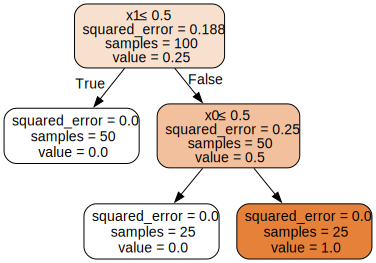

In [4]:
# build data
N = 100
M = 4
X = np.zeros((N, M))
X.shape
y = np.zeros(N)
X[: 1 * N // 4, 1] = 1
X[: N // 2, 0] = 1
X[N // 2 : 3 * N // 4, 1] = 1
y[: 1 * N // 4] = 1

# fit model
and_model = DecisionTreeRegressor(max_depth=2)
and_model.fit(X, y)

# draw model
dot_data = export_graphviz(and_model, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Explaining the model

Note that the bias term is the expected output of the model over the training dataset (0.25). The SHAP values for the unused features $x_2$ and $x_3$ are always 0. For $x_0$ and $x_1$ it is just the difference between the expected value (0.25) and the output of the model split equally between them (since they equally contribute to the AND function).

In [5]:
xs = np.array([np.ones(M), np.zeros(M)])
# np.array([np.ones(M), np.zeros(M), np.array([1, 0, 1, 0]), np.array([0, 1, 0, 0])]   # you can also check these examples
df = pd.DataFrame()
for idx, x in enumerate(xs):
    index = pd.MultiIndex.from_product([[f"Example {idx}"], ["x", "shap_values"]])
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [x, shap.TreeExplainer(and_model).shap_values(x)],
                index=index,
                columns=["x0", "x1", "x2", "x3"],
            ),
        ]
    )
df

x0     x1   x2   x3
Example 0 x            1.000  1.000  1.0  1.0
          shap_values  0.375  0.375  0.0  0.0
Example 1 x            0.000  0.000  0.0  0.0
          shap_values -0.125 -0.125  0.0  0.0

In [6]:
y.mean()

np.float64(0.25)

Here is how you get to the Shap values of Example 1: <br>
The bias term (`y.mean()`) is 0.25, and the target value is 1. This leaves 1 - 0.25 = 0.75 to split among the relevant features. Since only $x_0$ and $x_1$ contribute to the target value (and to the same extent), it is divided among them, i.e., 0.375 for each.

## Two features OR example

We do a slight variation of the example above. If $x_{0} = 1$ OR $x_{1} = 1$ the target is 1, else 0. Can you guess the SHAP values without scrolling down?

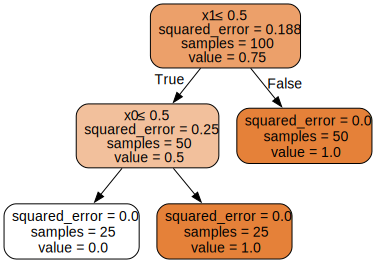

In [7]:
# build data
N = 100
M = 4
X = np.zeros((N, M))
X.shape
y = np.zeros(N)
X[: N // 2, 0] = 1
X[: 1 * N // 4, 1] = 1
X[N // 2 : 3 * N // 4, 1] = 1
y[: N // 2] = 1
y[N // 2 : 3 * N // 4] = 1

# fit model
or_model = DecisionTreeRegressor(max_depth=2)
or_model.fit(X, y)

# draw model
dot_data = export_graphviz(or_model, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Explaining the model

Note that the bias term is the expected output of the model over the training dataset (0.75). The SHAP value for features not used in the model is always 0, while for $x_0$ and $x_1$ it is just the difference between the expected value and the output of the model split equally between them (since they equally contribute to the OR function).

In [8]:
xs = np.array([np.ones(M), np.zeros(M)])
# np.array([np.ones(M), np.zeros(M), np.array([1, 0, 1, 0]), np.array([0, 1, 0, 0])]   # you can also check these examples
df = pd.DataFrame()
for idx, x in enumerate(xs):
    index = pd.MultiIndex.from_product([[f"Example {idx}"], ["x", "shap_values"]])
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [x, shap.TreeExplainer(or_model).shap_values(x)],
                index=index,
                columns=["x0", "x1", "x2", "x3"],
            ),
        ]
    )
df

x0     x1   x2   x3
Example 0 x            1.000  1.000  1.0  1.0
          shap_values  0.125  0.125  0.0  0.0
Example 1 x            0.000  0.000  0.0  0.0
          shap_values -0.375 -0.375  0.0  0.0

## Two feature XOR example

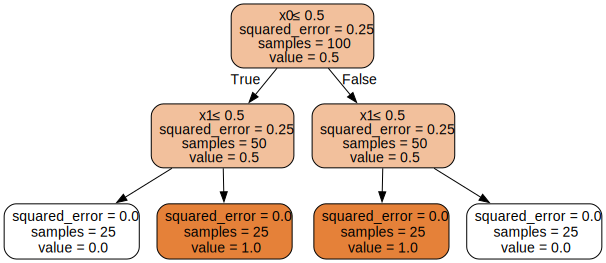

In [9]:
# build data
N = 100
M = 4
X = np.zeros((N, M))
X.shape
y = np.zeros(N)
X[: N // 2, 0] = 1
X[: 1 * N // 4, 1] = 1
X[N // 2 : 3 * N // 4, 1] = 1
y[1 * N // 4 : N // 2] = 1
y[N // 2 : 3 * N // 4] = 1

# fit model
xor_model = DecisionTreeRegressor(max_depth=2)
xor_model.fit(X, y)

# draw model
dot_data = export_graphviz(xor_model, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Explaining the model

Note that the bias term is the expected output of the model over the training dataset (0.5). The SHAP value for features not used in the model is always 0, while for $x_0$ and $x_1$ it is just the difference between the expected value and the output of the model split equally between them (since they equally contribute to the XOR function).

In [10]:
xs = np.array([np.ones(M), np.zeros(M)])
# np.array([np.ones(M), np.zeros(M), np.array([1, 0, 1, 0]), np.array([0, 1, 0, 0])]   # you can also check these examples
df = pd.DataFrame()
for idx, x in enumerate(xs):
    index = pd.MultiIndex.from_product([[f"Example {idx}"], ["x", "shap_values"]])
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [x, shap.TreeExplainer(xor_model).shap_values(x)],
                index=index,
                columns=["x0", "x1", "x2", "x3"],
            ),
        ]
    )
df

x0    x1   x2   x3
Example 0 x            1.00  1.00  1.0  1.0
          shap_values -0.25 -0.25  0.0  0.0
Example 1 x            0.00  0.00  0.0  0.0
          shap_values -0.25 -0.25  0.0  0.0

## Two features AND + feature boost example

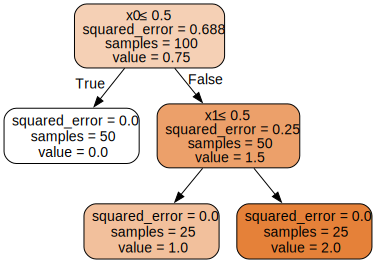

In [11]:
# build data
N = 100
M = 4
X = np.zeros((N, M))
X.shape
y = np.zeros(N)
X[: N // 2, 0] = 1
X[: 1 * N // 4, 1] = 1
X[N // 2 : 3 * N // 4, 1] = 1
y[: 1 * N // 4] = 1
y[: N // 2] += 1

# fit model
and_fb_model = DecisionTreeRegressor(max_depth=2)
and_fb_model.fit(X, y)

# draw model
dot_data = export_graphviz(and_fb_model, out_file=None, filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Explain the model

Note that the bias term is the expected output of the model over the training dataset (0.75). The SHAP value for features not used in the model is always 0, while for $x_0$ and $x_1$ it is just the difference between the expected value and the output of the model split equally between them (since they equally contribute to the AND function), plus an extra 0.5 impact for $x_0$ since it has an effect of $1.0$ all by itself (+0.5 if it is on and -0.5 if it is off).

In [12]:
xs = np.array([np.ones(M), np.zeros(M)])
# np.array([np.ones(M), np.zeros(M), np.array([1, 0, 1, 0]), np.array([0, 1, 0, 0])]   # you can also check these examples
df = pd.DataFrame()
for idx, x in enumerate(xs):
    index = pd.MultiIndex.from_product([[f"Example {idx}"], ["x", "shap_values"]])
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                [x, shap.TreeExplainer(and_fb_model).shap_values(x)],
                index=index,
                columns=["x0", "x1", "x2", "x3"],
            ),
        ]
    )
df

x0     x1   x2   x3
Example 0 x            1.000  1.000  1.0  1.0
          shap_values  0.875  0.375  0.0  0.0
Example 1 x            0.000  0.000  0.0  0.0
          shap_values -0.625 -0.125  0.0  0.0